Evaluation (for TFIDF-RF)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions

In [3]:
DATASET_SIZE = 120
DATASET_IS_BALANCED = True


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_name = 'tfidf-fa-{}_{}k_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal'
)

training_args_datetime = datetime(year=2023, month=12, day=18)
training_storing_folder = Path(training_name).resolve()

dataset_traintest, X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_presampled_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

X_train, X_test, y_train, y_test = dataset_loader.create_traintest_dataset(dataset_traintest)

Loaded dataset size: 120k, is_balanced: True
Validation dataset imbalanced class distribution
review_score
1    774377
0    150928
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
0    150672
1    150672
Name: count, dtype: int64



Training dataset class distribution
review_score
0    54060
1    53940
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    6060
0    5940
Name: count, dtype: int64





In [4]:
# data cleaning function

def cleaning_arr(str_arr):
    '''apply all cleaning functions to a numpy array, or a pandas series object'''
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_num(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_symbols(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_punctuation(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))

    return str_arr

In [5]:
# applying data cleaning to all datasets
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

X_bal_valid = X_bal_valid.to_numpy()
y_bal_valid = y_bal_valid.to_numpy()

X_imbal_valid = X_imbal_valid.to_numpy()
y_imbal_valid = y_imbal_valid.to_numpy()


X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [6]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

validation (balanced) set datatype
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


---

Load the models (optional)

In [7]:
from datetime import datetime
import pickle

rf_model_path = Path.joinpath(training_storing_folder, "{}_{}_model.sav".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
model = pickle.load(open(rf_model_path, 'rb'))

count_vectorizer_path = Path.joinpath(training_storing_folder, "{}_{}_count_vectorizer.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
vectorizer = pickle.load(open(count_vectorizer_path, 'rb'))

tfidf_transformer_path = Path.joinpath(training_storing_folder, "{}_{}_tfidf.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
tfidf = pickle.load(open(tfidf_transformer_path, 'rb'))

print('Loaded model from {}'.format(rf_model_path))
print('Loaded count vectorizer from {}'.format(count_vectorizer_path))
print('Loaded tfidf transformer from {}'.format(tfidf_transformer_path))

Loaded model from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-fa-20000_120k_bal/tfidf-fa-20000_120k_bal_2023-12-18_model.sav
Loaded count vectorizer from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-fa-20000_120k_bal/tfidf-fa-20000_120k_bal_2023-12-18_count_vectorizer.pkl
Loaded tfidf transformer from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-fa-20000_120k_bal/tfidf-fa-20000_120k_bal_2023-12-18_tfidf.pkl


---

Evaluation

In [8]:
from sklearn.pipeline import Pipeline

pipeline_test = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf),
    ('model', model),
])

on test set

In [9]:
y_test_pred_prob_raw = pipeline_test.predict_proba(X_test)

y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.3s


In [10]:
evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      5940
           1       0.83      0.78      0.81      6060

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000



TN - True Negative 4975
FN - False Negative 1320
TP - True Positive 4740
FP - False Positive 965
Accuracy Rate: 0.8095833333333333
Misclassification Rate: 0.19041666666666668
F1-Score: 0.8095102792025621
ROC-AUC 0.809860152681935


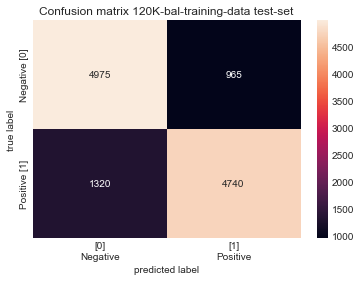

In [14]:
import matplotlib as plt
plt.style.use('seaborn-v0_8-dark')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=False
)

0.5139202948072584


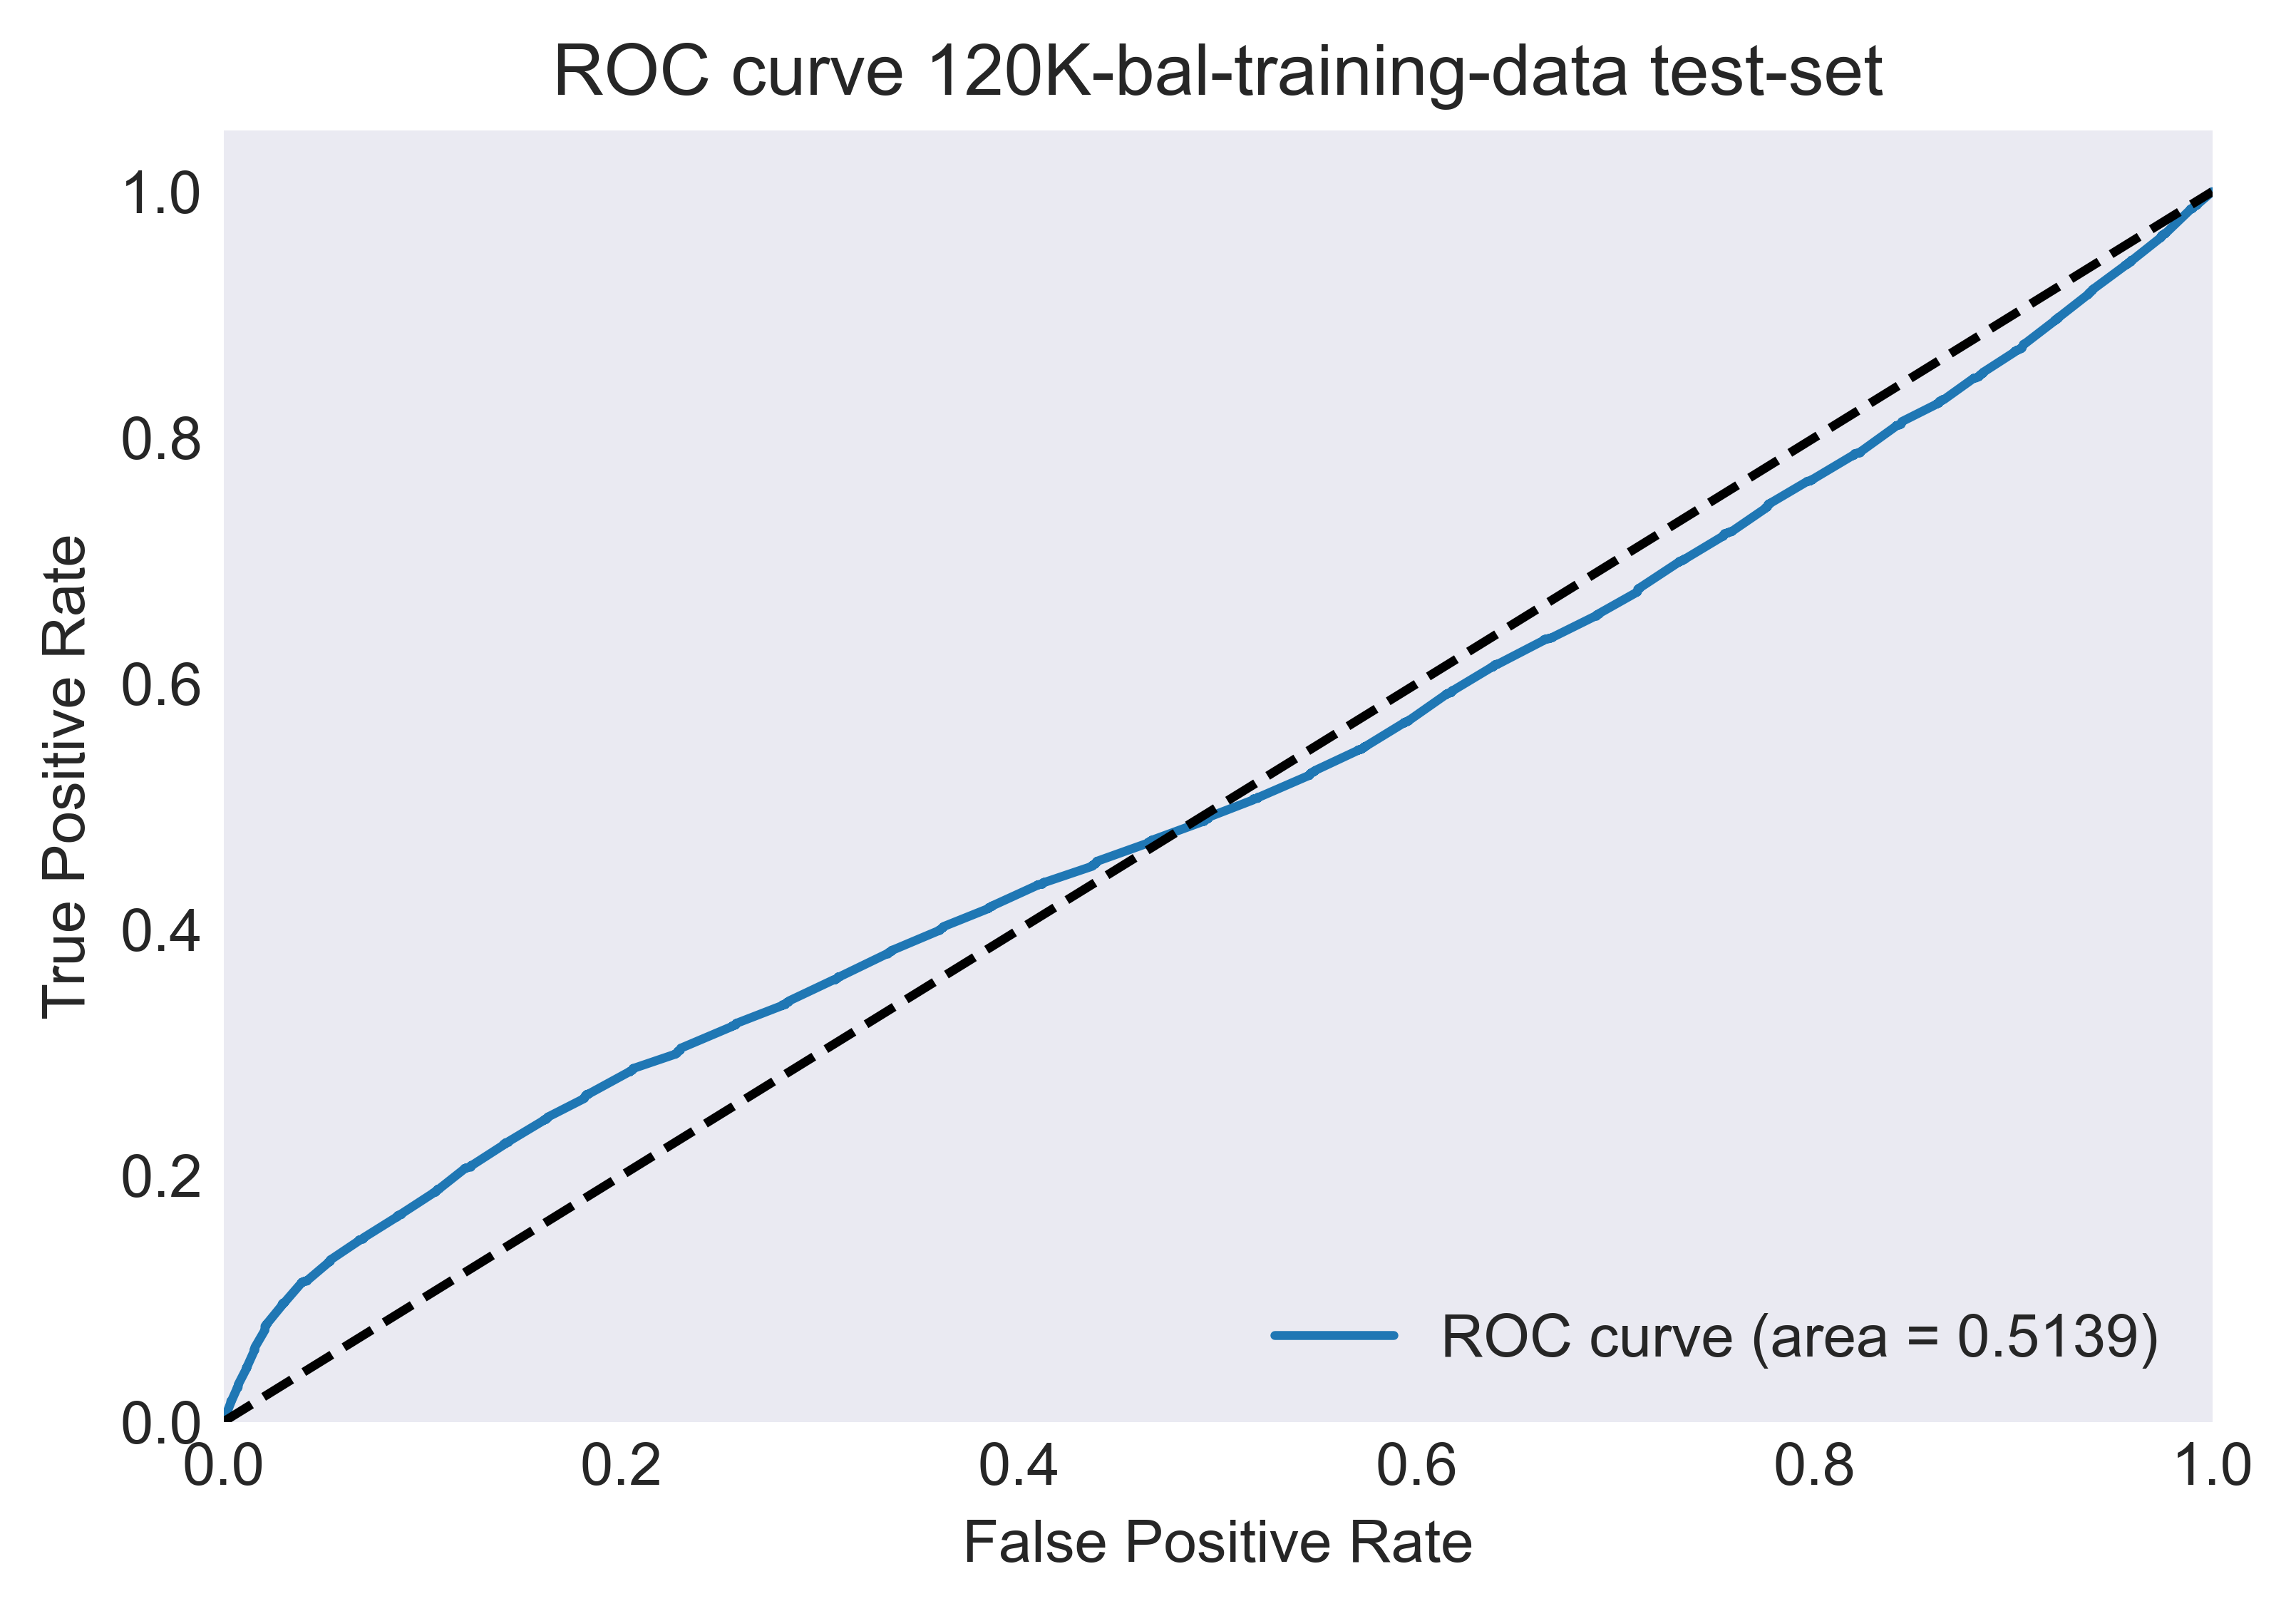

In [15]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=False
)

on fixed balanced validation set

In [16]:
y_bal_valid_pred_prob_raw = pipeline_test.predict_proba(X_bal_valid)

y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    5.9s


In [17]:
evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82    150672
           1       0.83      0.78      0.81    150672

    accuracy                           0.81    301344
   macro avg       0.81      0.81      0.81    301344
weighted avg       0.81      0.81      0.81    301344



TN - True Negative 126760
FN - False Negative 32541
TP - True Positive 118131
FP - False Positive 23912
Accuracy Rate: 0.8126626048635447
Misclassification Rate: 0.18733739513645534
F1-Score: 0.8125088685119024
ROC-AUC 0.8126626048635446


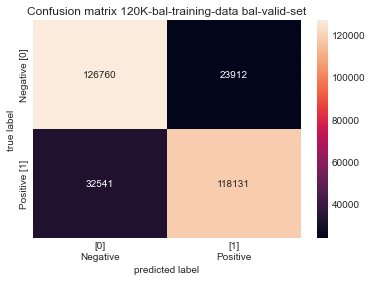

In [18]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=False)

0.5085115799021523


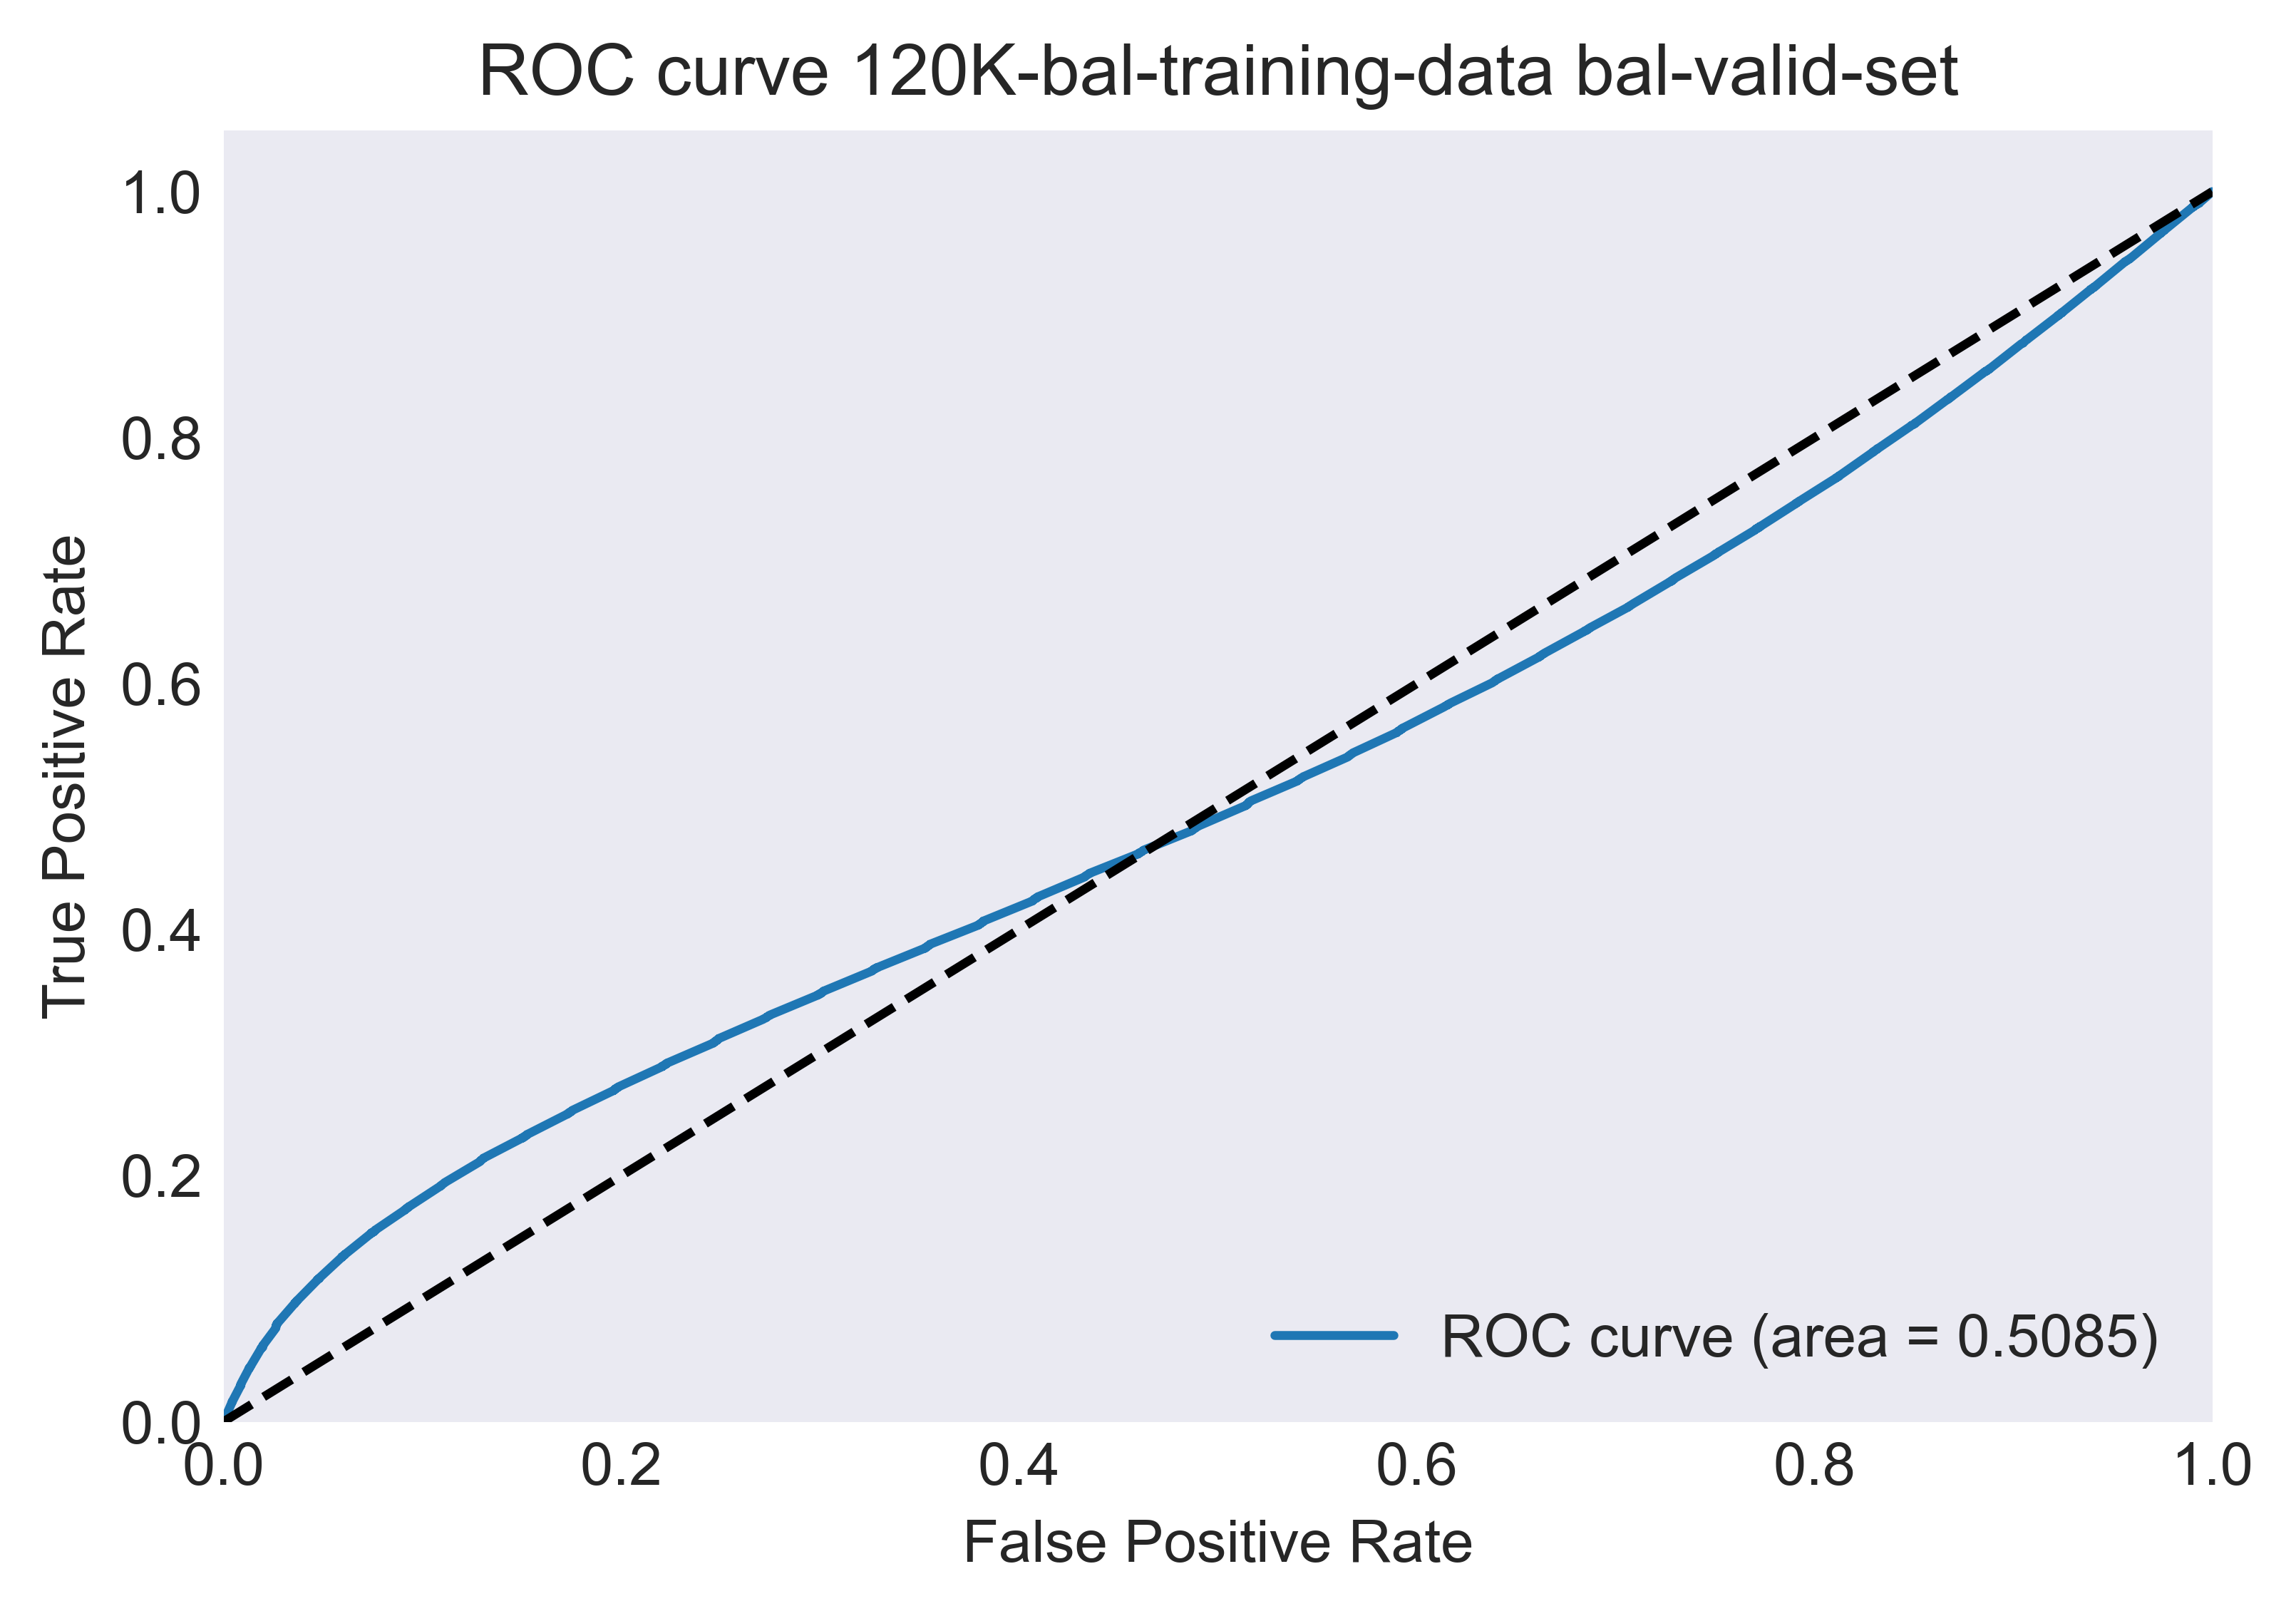

In [19]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=False)

on fixed validation set (imbalanced)

In [20]:
y_imbal_valid_pred_prob_raw = pipeline_test.predict_proba(X_imbal_valid)

y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   19.4s


In [21]:
evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.43      0.84      0.57    150928
           1       0.96      0.79      0.86    774377

    accuracy                           0.79    925305
   macro avg       0.70      0.81      0.72    925305
weighted avg       0.88      0.79      0.82    925305



TN - True Negative 126941
FN - False Negative 166049
TP - True Positive 608328
FP - False Positive 23987
Accuracy Rate: 0.7946233944483171
Misclassification Rate: 0.20537660555168297
F1-Score: 0.7184088400966284
ROC-AUC 0.8133203832856659


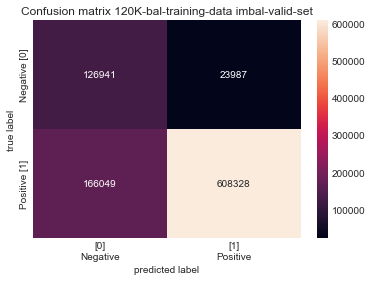

In [22]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "ßimbal"}-training-data imbal-valid-set',
    save=False)

0.5100435896380651


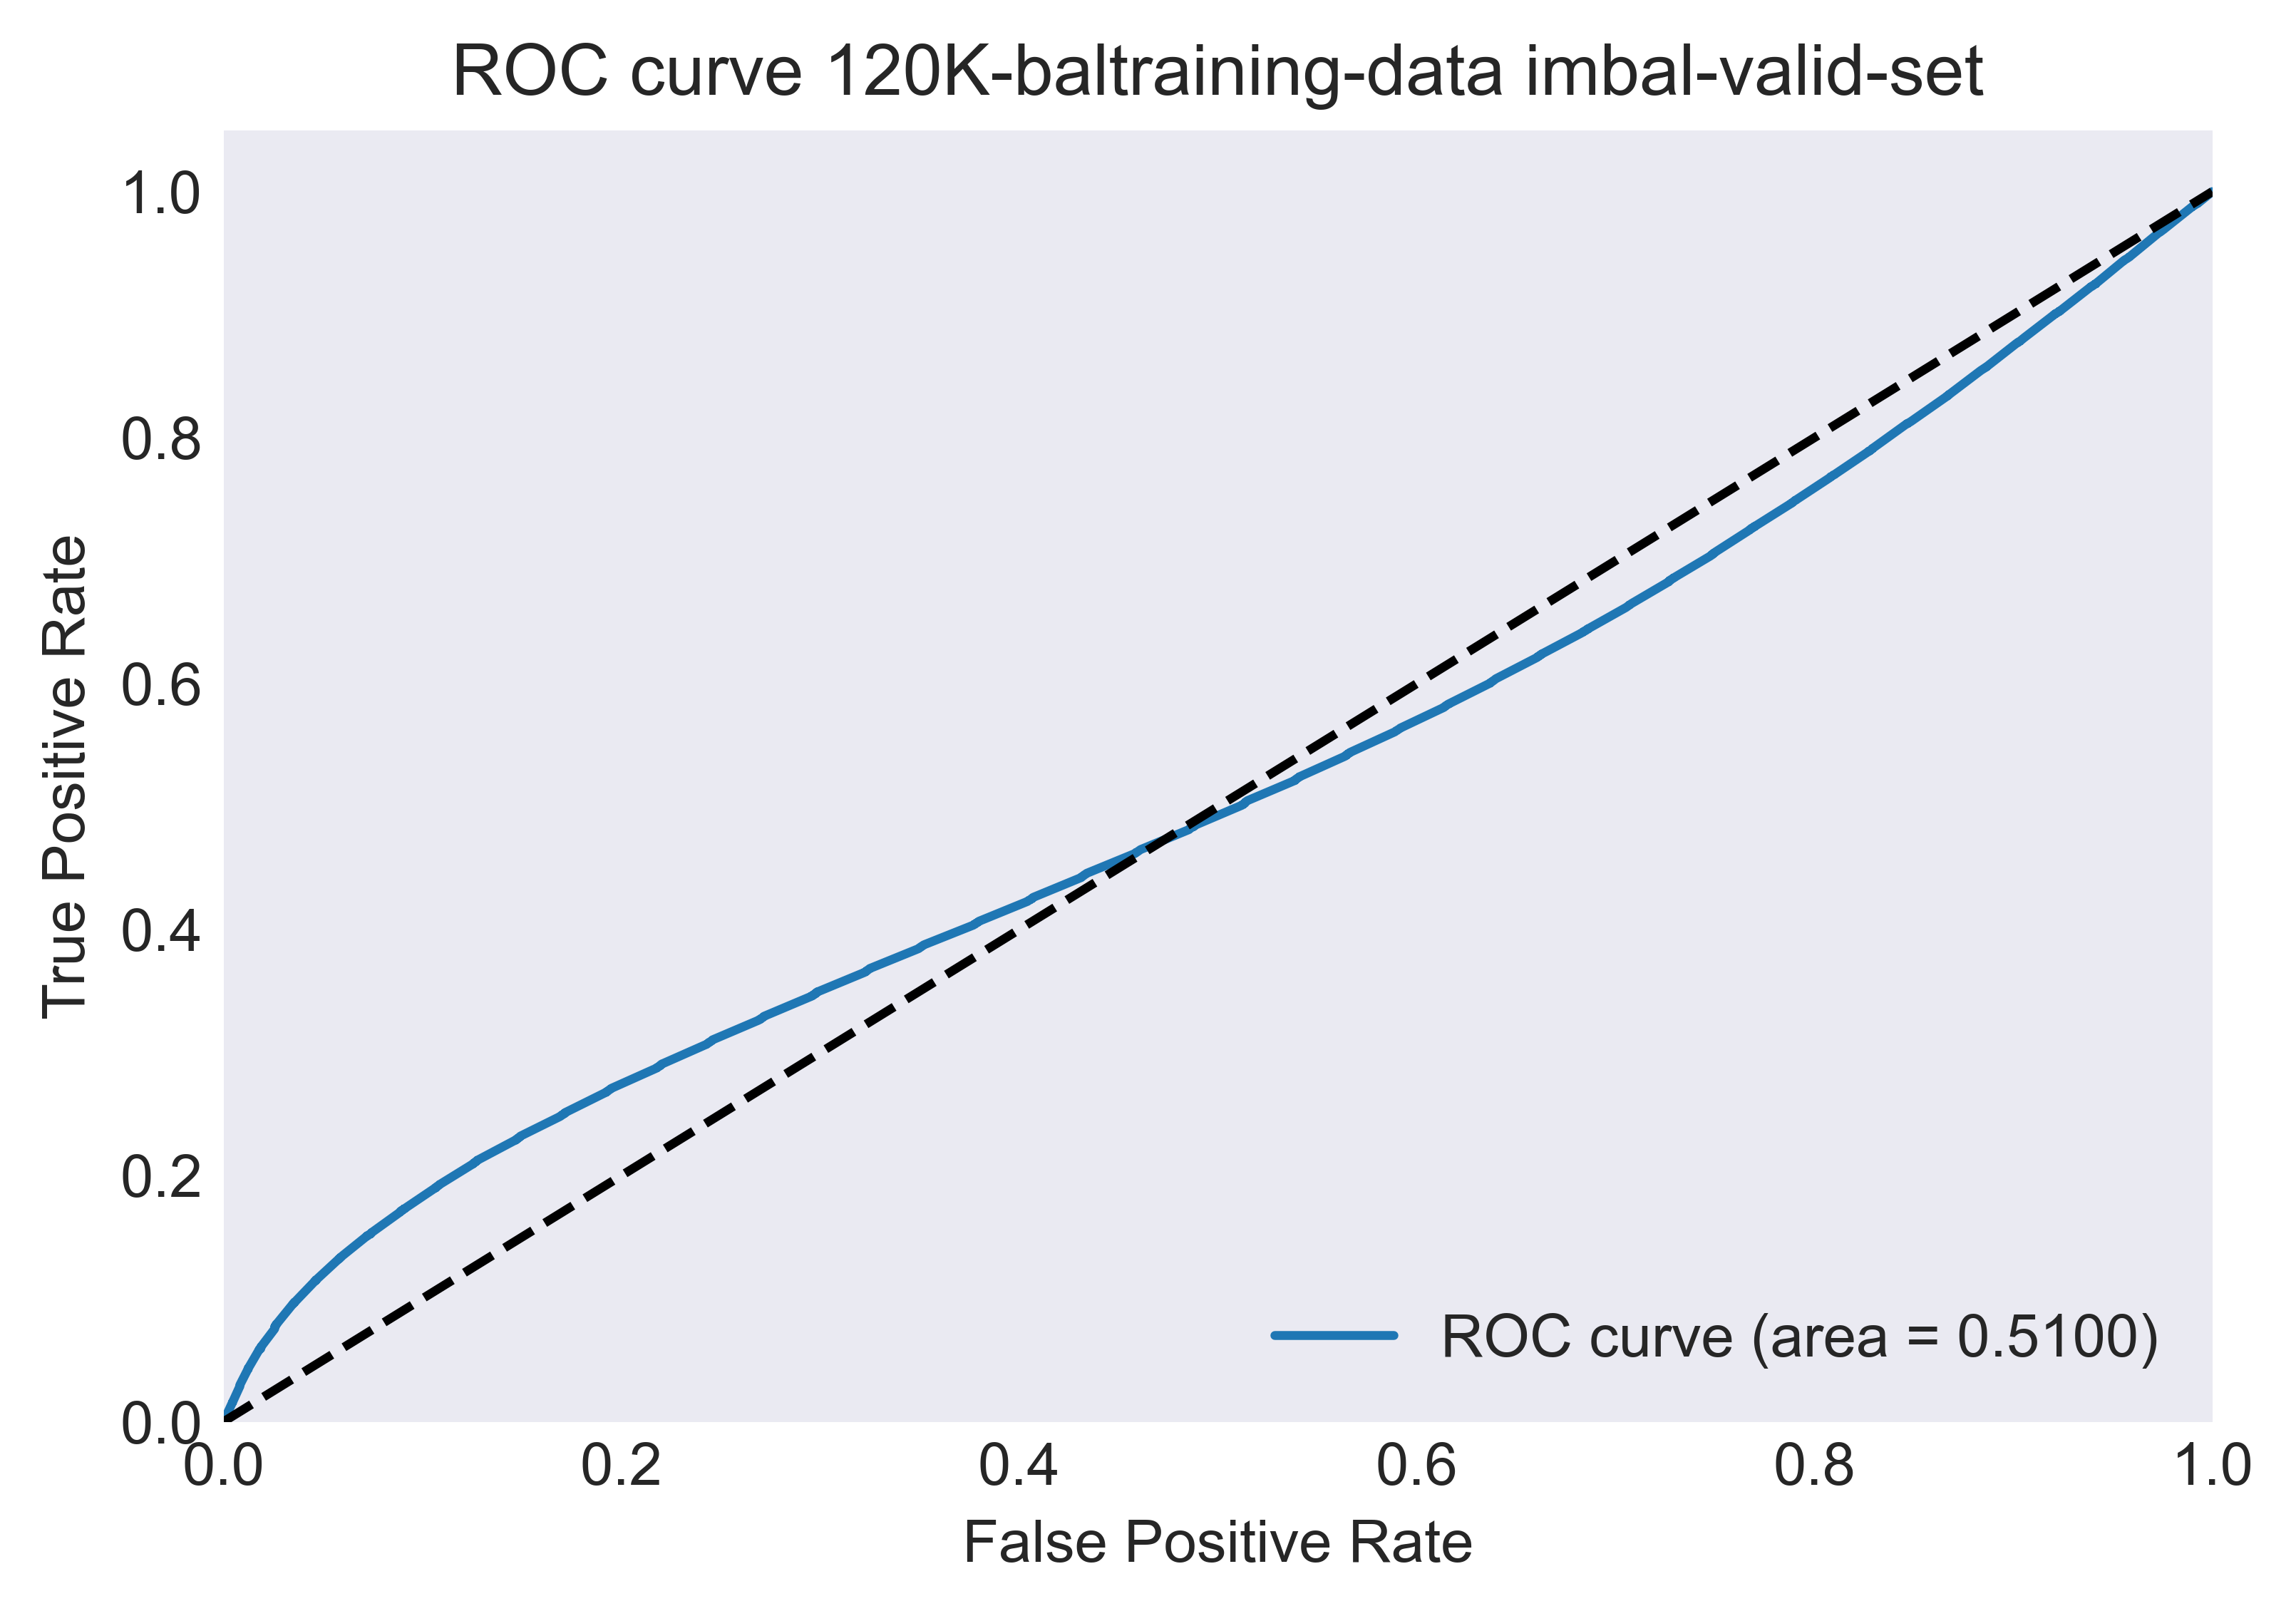

In [23]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}training-data imbal-valid-set',
    save=False)

Evluation end